In [0]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import math
import time
import os
import sys
import matplotlib.pyplot as plt

In [0]:
def conv_block(input_channels, num_channels):
    layers = []
    layers.append(nn.BatchNorm2d(input_channels))
    layers.append(nn.ReLU())
    layers.append(nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))
    blk = nn.Sequential(*layers)
    return blk

In [0]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels, **kwargs):
        super(DenseBlock, self).__init__(**kwargs)
        layer = []
        for i in range(num_convs):
            layer.append(conv_block((num_channels * i + input_channels), num_channels))
        self.net = nn.Sequential(*layer)
    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate the input and output of each block on the channel
            # dimension
            X = torch.cat((X, Y), dim=1)
        return X

In [4]:

blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

In [0]:
def transition_block(input_channels, num_channels):
    layers = []
    layers.append(nn.BatchNorm2d(input_channels))
    layers.append(nn.ReLU())
    layers.append(nn.Conv2d(input_channels, num_channels, kernel_size=1))
    layers.append(nn.AvgPool2d(kernel_size=2, stride=2))
    blk = nn.Sequential(*layers)
    return blk

In [0]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1,1,96,96)

layers = []
layers.append(Reshape())
layers.append(nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3))
layers.append(nn.BatchNorm2d(64))
layers.append(nn.ReLU())
layers.append(nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [0]:
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    layers.append(DenseBlock(num_convs, num_channels, growth_rate))
    # This is the number of output channels in the previous dense block
    num_channels += num_convs * growth_rate
    # A transition layer that haves the number of channels is added between
    # the dense blocks
    if i != len(num_convs_in_dense_blocks) - 1:
        layers.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

In [0]:
layers.append(nn.BatchNorm2d(num_channels))
layers.append(nn.ReLU())
layers.append(nn.AdaptiveMaxPool2d((1,1)))
layers.append(Flatten())
layers.append(nn.Linear(num_channels, 10))

net = nn.Sequential(*layers)

In [0]:
lr, num_epochs, batch_size, device = 0.1, 5, 64, 'cuda:0'

In [11]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        
net.apply(init_weights)


Sequential(
  (0): Reshape()
  (1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (5): DenseBlock(
    (net): Sequential(
      (0): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): Sequential(
        (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
   

In [0]:
net = net.to(device)

In [0]:
criterion = nn.CrossEntropyLoss()

In [0]:
def load_data_fashion_mnist(batch_size, resize=None, root=os.path.join(
        '~', '.pytorch', 'datasets', 'fashion-mnist')):
    """Download the Fashion-MNIST dataset and then load into memory."""
    root = os.path.expanduser(root)
    transformer = []
    if resize:
        transformer += [transforms.Resize(resize)]
    transformer += [transforms.ToTensor()]
    transformer = transforms.Compose(transformer)

    mnist_train = torchvision.datasets.FashionMNIST(root=root, train=True, transform=transformer, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root=root, train=False, transform=transformer, download=True)
    num_workers = 0 if sys.platform.startswith('win32') else 4

    train_iter =torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers)
    test_iter =torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=num_workers)
    return train_iter, test_iter

In [0]:

def train_ch5(net, train_iter, test_iter, criterion, num_epochs, batch_size, device, lr=None):
    """Train and evaluate a model with CPU or GPU."""
    print('training on', device)
    net.to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr)
    for epoch in range(num_epochs):
        net.train() # Switch to training mode
        n, start = 0, time.time()
        train_l_sum = torch.tensor([0.0], dtype=torch.float32, device=device)
        train_acc_sum = torch.tensor([0.0], dtype=torch.float32, device=device)
        for X, y in train_iter:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device) 
            y_hat = net(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                y = y.long()
                train_l_sum += loss.float()
                train_acc_sum += (torch.sum((torch.argmax(y_hat, dim=1) == y))).float()
                n += y.shape[0]

        test_acc = evaluate_accuracy(test_iter, net, device) 
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'\
            % (epoch + 1, train_l_sum/n, train_acc_sum/n, test_acc, time.time() - start))

In [0]:
def evaluate_accuracy(data_iter, net, device=torch.device('cpu')):
    """Evaluate accuracy of a model on the given data set."""
    net.eval()  # Switch to evaluation mode for Dropout, BatchNorm etc layers.
    acc_sum, n = torch.tensor([0], dtype=torch.float32, device=device), 0
    for X, y in data_iter:
        # Copy the data to device.
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            y = y.long()
            acc_sum += torch.sum((torch.argmax(net(X), dim=1) == y))
            n += y.shape[0]
    return acc_sum.item()/n

In [17]:
train_iter, test_iter =load_data_fashion_mnist(batch_size, resize=96)
train_ch5(net, train_iter, test_iter, criterion, num_epochs, batch_size, device, lr)

0it [00:00, ?it/s]

26427392it [00:02, 13062097.58it/s]                              


Extracting /root/.pytorch/datasets/fashion-mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/datasets/fashion-mnist/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 93391.38it/s]                            
0it [00:00, ?it/s]

Extracting /root/.pytorch/datasets/fashion-mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/datasets/fashion-mnist/FashionMNIST/raw


4423680it [00:01, 4067718.37it/s]                             
0it [00:00, ?it/s]

Extracting /root/.pytorch/datasets/fashion-mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/datasets/fashion-mnist/FashionMNIST/raw


8192it [00:00, 30178.19it/s]            

Extracting /root/.pytorch/datasets/fashion-mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/datasets/fashion-mnist/FashionMNIST/raw
Processing...
Done!
training on cuda:0


epoch 1, loss 0.0092, train acc 0.806, test acc 0.816, time 82.0 sec
epoch 2, loss 0.0048, train acc 0.886, test acc 0.860, time 81.7 sec
epoch 3, loss 0.0040, train acc 0.906, test acc 0.901, time 81.8 sec
epoch 4, loss 0.0036, train acc 0.915, test acc 0.896, time 81.9 sec
epoch 5, loss 0.0032, train acc 0.923, test acc 0.899, time 81.9 sec


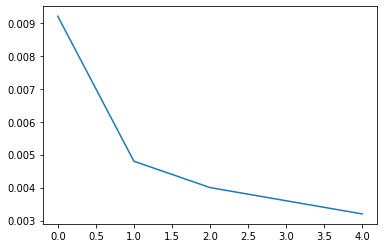

In [18]:
loss=[0.0092,0.0048,0.0040,0.0036,0.0032]
plt.plot(loss)

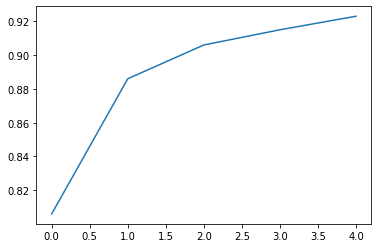

In [19]:
train_acc=[0.806,0.886,0.906,0.915,0.923]
plt.plot(train_acc)

In [20]:

examples = enumerate(test_iter)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([64, 1, 96, 96])

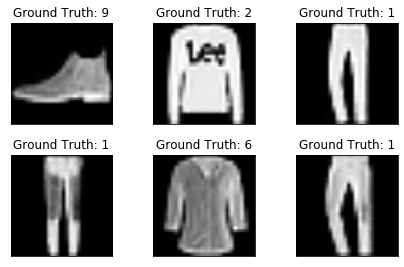

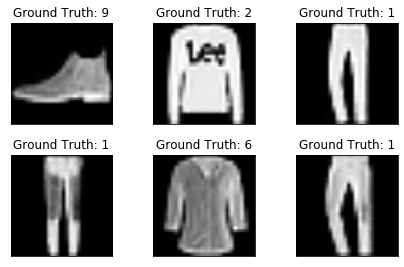

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig